<a href="https://colab.research.google.com/github/GusdPaula/ML_interview/blob/main/pytorch_interview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch.utils.data as data_utils

In [15]:
from torch import nn
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
path_df = "/content/plant_disease_dataset.csv"
df = pd.read_csv(path_df)
df.head(5)

,temperature,humidity,rainfall,soil_pH,disease_present
0,27.483571,33.215053,0.572758,4.975875,1
1,24.308678,36.945005,42.522346,8.165266,0
2,28.238443,34.026189,16.095303,6.316734,1
3,32.615149,41.104180,20.311015,6.164949,0
4,23.829233,51.971785,11.851323,8.482468,0


In [5]:
df.isnull().any().sum()

np.int64(0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      10000 non-null  float64
 1   humidity         10000 non-null  float64
 2   rainfall         10000 non-null  float64
 3   soil_pH          10000 non-null  float64
 4   disease_present  10000 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 390.8 KB


In [7]:
df.describe()

,temperature,humidity,rainfall,soil_pH,disease_present
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,25.612191,62.119300,9.807522,6.245855,0.241000
std,5.813841,22.679977,9.852130,1.302465,0.427712
min,5.387999,6.244209,0.000055,4.000075,0.000000
25%,21.815610,40.772925,2.812822,5.122970,0.000000
50%,25.293238,72.211752,6.864898,6.232188,0.000000
75%,28.916048,81.032999,13.442871,7.386377,0.000000
max,56.686495,102.395421,84.654161,8.499875,1.000000


In [8]:
df['disease_present'].value_counts(normalize=True)

,proportion
disease_present,
0,0.759
1,0.241


In [9]:
X = df.drop('disease_present', axis=1)
y = df['disease_present']

X = torch.from_numpy(X.to_numpy()).type(torch.float).to(device)
y = torch.from_numpy(y.to_numpy()).type(torch.float).to(device)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(4, 64)
    self.fc2 = nn.Linear(64, 128)
    self.fc3 = nn.Linear(128, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [32]:
model_0 = Model().to(device)

# Create the loss function
loss_fn = nn.BCEWithLogitsLoss() # nn.BCELoss() for binary classification

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [33]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [34]:
def run_model():
  torch.manual_seed(42)

  # Set the number of epochs (how many times the model will pass over the training data)
  epochs = 1000

  # Create empty loss lists to track values
  train_loss_values = []
  test_loss_values = []
  epoch_count = []

  for epoch in range(epochs):
      ### Training

      # Put model in training mode (this is the default state of a model)
      model_0.train()

      # 1. Forward pass (model outputs raw logits)
      y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
      y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

      # 2. Calculate loss/accuracy
      # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
      #                y_train)
      loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                    y_train)
      acc = accuracy_fn(y_true=y_train,
                        y_pred=y_pred)

      # 3. Zero grad of the optimizer
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Progress the optimizer
      optimizer.step()

      ### Testing

      # Put the model in evaluation mode
      model_0.eval()

      with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)

      # Print out what's happening every 10 epochs
      if epoch % 100 == 0:
          print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

  print(classification_report(y_test.cpu(), test_pred.cpu()))

In [35]:
run_model()

Epoch: 0 | Loss: 0.69590, Accuracy: 50.36% | Test loss: 0.69823, Test acc: 48.55%
Epoch: 100 | Loss: 0.69262, Accuracy: 50.36% | Test loss: 0.69354, Test acc: 48.55%
Epoch: 200 | Loss: 0.69078, Accuracy: 55.31% | Test loss: 0.69142, Test acc: 53.03%
Epoch: 300 | Loss: 0.68906, Accuracy: 59.28% | Test loss: 0.68968, Test acc: 57.25%
Epoch: 400 | Loss: 0.68736, Accuracy: 61.21% | Test loss: 0.68802, Test acc: 59.85%
Epoch: 500 | Loss: 0.68566, Accuracy: 61.95% | Test loss: 0.68638, Test acc: 61.00%
Epoch: 600 | Loss: 0.68395, Accuracy: 62.81% | Test loss: 0.68473, Test acc: 61.76%
Epoch: 700 | Loss: 0.68221, Accuracy: 63.54% | Test loss: 0.68305, Test acc: 62.35%
Epoch: 800 | Loss: 0.68043, Accuracy: 63.92% | Test loss: 0.68134, Test acc: 63.01%
Epoch: 900 | Loss: 0.67861, Accuracy: 64.48% | Test loss: 0.67959, Test acc: 63.64%
              precision    recall  f1-score   support

         0.0       0.71      0.51      0.59      1562
         1.0       0.60      0.78      0.68      1474

In [36]:
X = df.drop('disease_present', axis=1)
y = df['disease_present']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
import xgboost as xgb

In [38]:
xgb_model = xgb.XGBClassifier(random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1518
           1       0.77      0.56      0.65       482

    accuracy                           0.85      2000
   macro avg       0.82      0.75      0.78      2000
weighted avg       0.85      0.85      0.84      2000



In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

In [41]:
cm = confusion_matrix(y_test, y_pred)

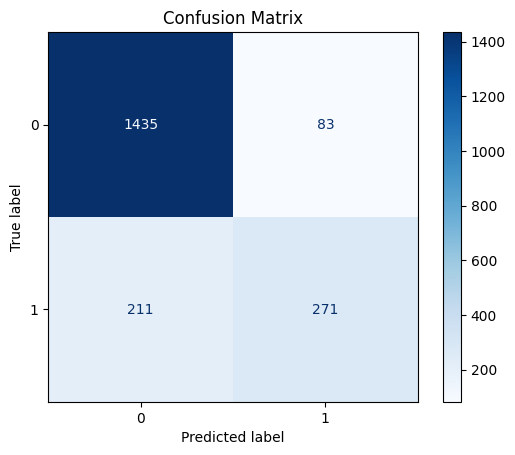

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [43]:
from imblearn.over_sampling import SMOTE

In [44]:
X = df.drop('disease_present', axis=1)
y = df['disease_present']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [45]:
X_resampled = torch.from_numpy(X_resampled.to_numpy()).type(torch.float).to(device)
y_resampled = torch.from_numpy(y_resampled.to_numpy()).type(torch.float).to(device)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [46]:
run_model()

Epoch: 0 | Loss: 5.11782, Accuracy: 50.39% | Test loss: 18.93764, Test acc: 51.45%
Epoch: 100 | Loss: 0.65523, Accuracy: 62.66% | Test loss: 0.65310, Test acc: 61.46%
Epoch: 200 | Loss: 0.62824, Accuracy: 65.86% | Test loss: 0.63194, Test acc: 64.30%
Epoch: 300 | Loss: 0.62436, Accuracy: 66.59% | Test loss: 0.62865, Test acc: 64.89%
Epoch: 400 | Loss: 0.62324, Accuracy: 66.86% | Test loss: 0.62718, Test acc: 65.35%
Epoch: 500 | Loss: 0.62228, Accuracy: 67.05% | Test loss: 0.62590, Test acc: 65.55%
Epoch: 600 | Loss: 0.62112, Accuracy: 67.11% | Test loss: 0.62454, Test acc: 65.88%
Epoch: 700 | Loss: 0.61999, Accuracy: 67.13% | Test loss: 0.62326, Test acc: 66.07%
Epoch: 800 | Loss: 0.61884, Accuracy: 67.24% | Test loss: 0.62203, Test acc: 66.30%
Epoch: 900 | Loss: 0.61814, Accuracy: 67.33% | Test loss: 0.62109, Test acc: 66.17%
              precision    recall  f1-score   support

         0.0       0.73      0.54      0.62      1562
         1.0       0.62      0.79      0.69      147

In [47]:
from sklearn.preprocessing import MinMaxScaler

X = df.drop('disease_present', axis=1)
y = df['disease_present']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)
y_resampled = torch.from_numpy(y_resampled.to_numpy()).type(torch.float).to(device)
X_resampled = torch.from_numpy(X_scaled).type(torch.float).to(device)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [48]:
run_model()

Epoch: 0 | Loss: 0.69272, Accuracy: 49.64% | Test loss: 0.68965, Test acc: 51.45%
Epoch: 100 | Loss: 0.68774, Accuracy: 49.58% | Test loss: 0.68676, Test acc: 51.42%
Epoch: 200 | Loss: 0.68570, Accuracy: 62.16% | Test loss: 0.68558, Test acc: 63.27%
Epoch: 300 | Loss: 0.68409, Accuracy: 64.25% | Test loss: 0.68435, Test acc: 64.69%
Epoch: 400 | Loss: 0.68250, Accuracy: 64.12% | Test loss: 0.68296, Test acc: 64.30%
Epoch: 500 | Loss: 0.68086, Accuracy: 64.08% | Test loss: 0.68144, Test acc: 64.33%
Epoch: 600 | Loss: 0.67914, Accuracy: 64.39% | Test loss: 0.67982, Test acc: 64.33%
Epoch: 700 | Loss: 0.67735, Accuracy: 64.78% | Test loss: 0.67811, Test acc: 64.59%
Epoch: 800 | Loss: 0.67545, Accuracy: 65.04% | Test loss: 0.67630, Test acc: 64.62%
Epoch: 900 | Loss: 0.67347, Accuracy: 65.28% | Test loss: 0.67441, Test acc: 64.76%
              precision    recall  f1-score   support

         0.0       0.69      0.58      0.63      1562
         1.0       0.62      0.73      0.67      1474